In [1]:
from fastai.tabular import *
from fastai.callbacks import LearnerCallback
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score
import seaborn as sns
import shap
import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

import lightgbm as lgb

import feather
import pickle
import itertools
from collections import deque
from joblib import Parallel, delayed
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

path = Path('/home/marco/data/working/santander')

class roc(Callback):
    '''
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, num_batch, **kwargs):
        self.metric = self.total/self.batch_count

### Load model

In [2]:
train_df = pd.read_csv(path/'train.csv')
train_df.pop('ID_code')

test_df = pd.read_csv(path/'test.csv')
test_ID_codes_df = test_df.pop('ID_code')

keep_cols = list(train_df.columns[1:])
len(keep_cols)

200

### EDA

In [4]:
train_df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697,2.4354,0.8194,16.5346,1

https://towardsdatascience.com/my-secret-sauce-to-be-in-top-2-of-a-kaggle-competition-57cff0677d3c

If dependent variable (target) is binary, scatter plots don’t work because all points lie either at 0 or 1. For continuous target, too many data points make it difficult to understand the target vs. feature trend. Featexp creates better plots which help with this problem. Let’s try it out!

Featexp creates equal population bins (X-axis) of a numeric feature. It then calculates target’s mean in each bin and plots it in the left-hand side plot above. 

Noisy features have bad correlation between the train and test(valid) trend plots, we should examine these and drop them

                                           Plots for var_0                                            
                                           Train data plots                                           


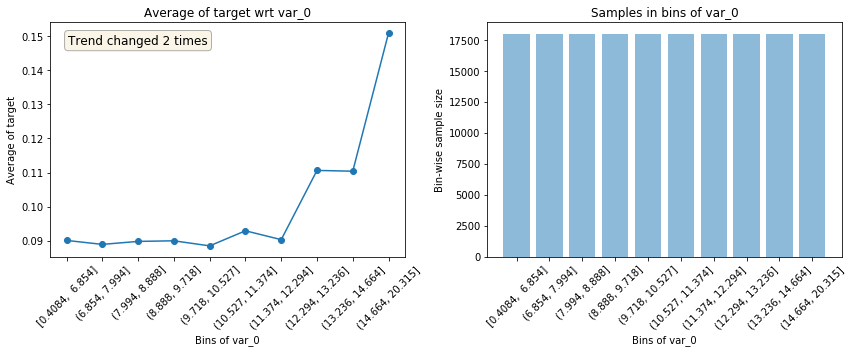

                                           Test data plots                                            


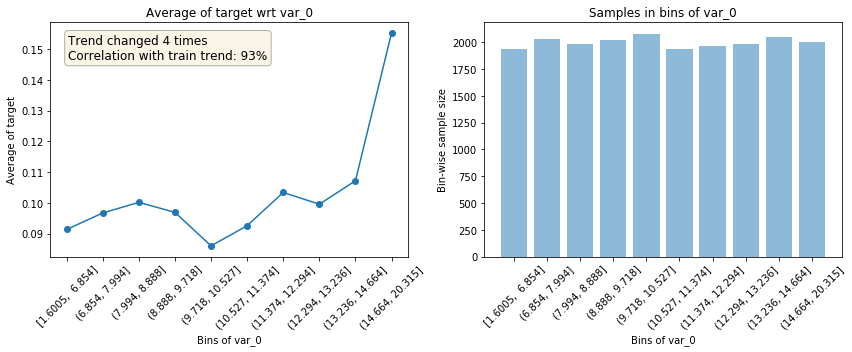

--------------------------------------------------------------------------------------------------------------


                                           Plots for var_1                                            
                                           Train data plots                                           


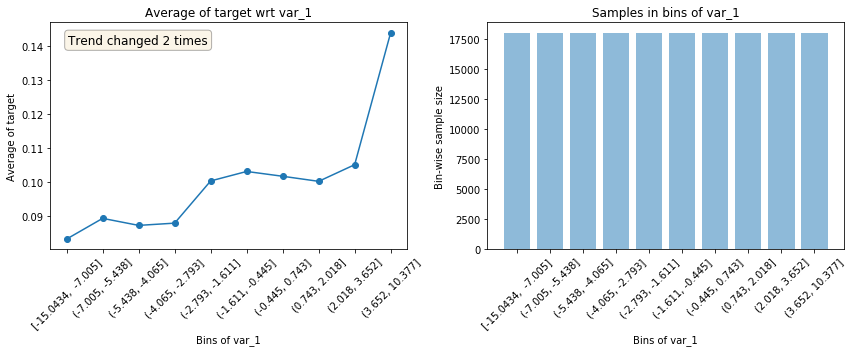

                                           Test data plots                                            


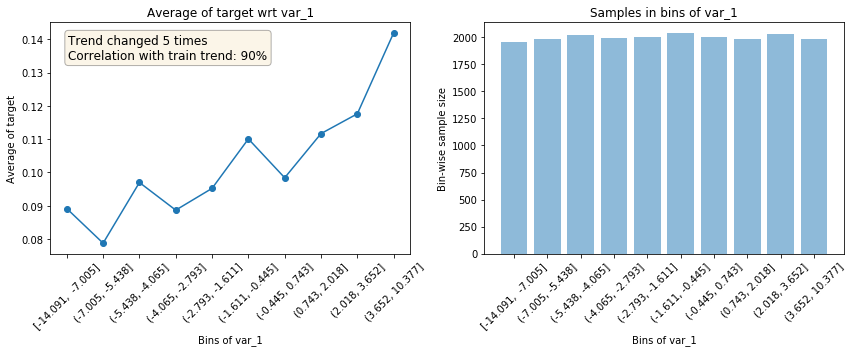

--------------------------------------------------------------------------------------------------------------




In [5]:
from featexp import get_univariate_plots

train_df_len = len(train_df)
train_idx = range(0, round(0.90*train_df_len))
valid_idx = range(round(0.90*train_df_len), train_df_len)

train_df_proper = train_df.iloc[train_idx, :]
valid_df = train_df.iloc[valid_idx, :]

# Plots drawn for all features if nothing is passed in feature_list parameter.
get_univariate_plots(data=train_df_proper, target_col='target', data_test=valid_df,
                     features_list=train_df.columns[1:][0:2], bins=10)

In [14]:
from featexp import get_trend_stats
stats = get_trend_stats(data=train_df_proper, target_col='target', data_test=valid_df)
#stats

Returning stats for all numeric features


In [15]:
keep_cols_stats = stats[stats.Trend_correlation>0.50].Feature.values.tolist()
len(keep_cols_stats)

154

#### Interaction Features

In [6]:
def interaction_features(c1,c2): return pd.Series(c1*c1*c2, name=f"{c1.name}_{c1.name}_{c2.name}")

def parallel_interaction_features(df, cols):
    return Parallel(32)(delayed(interaction_features)(
        df[c1], df[c2]) for c1,c2 in tqdm(list(itertools.permutations(cols, 2))))


int_feat_train = parallel_interaction_features(train_df, keep_cols_stats)
int_feat_test = parallel_interaction_features(test_df, keep_cols_stats)

100%|██████████| 992/992 [00:00<00:00, 4201.91it/s]


In [7]:
keep_cols_feats = keep_cols_stats + [o.name for o in int_feat_train]

In [8]:
int_feat_train = pd.DataFrame({o.name:o.values for o in int_feat_train})
int_feat_test = pd.DataFrame({o.name:o.values for o in int_feat_test})

In [9]:
train_df = train_df.join(int_feat_train)
test_df = test_df.join(int_feat_test)

In [10]:
del int_feat_train
del int_feat_test

In [11]:
keep_cols = keep_cols_feats
len(keep_cols)

1024

In [28]:
train_df.to_feather(path/'train_df.feather')
test_df.to_feather(path/'test_df.feather')
with open(path/'keep_cols.pkl', 'wb') as f: pickle.dump(keep_cols, f)

### Feat importance

In [3]:
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1)
#X = train_df[keep_cols_stats]
#y = train_df[train_df_proper.columns[0]]
X = train_df[keep_cols]
y = train_df[train_df.columns[0]]

In [9]:
train_df_len = len(train_df)
valid_idx = np.random.permutation(range(train_df_len))[:train_df_len//20]
train_idx = list(set(range(train_df_len)) - set(valid_idx))

In [4]:
rf.fit(X,y)

KeyboardInterrupt: 

In [ ]:
I = rfpimp.importances(rf, X, y)
#I.plot(kind='barh', legend=False)

In [ ]:
#I.Importance

In [ ]:
keep_cols_imp = I.Importance[I.Importance>0.01].index.tolist()
len(keep_cols_imp)

In [15]:
keep_cols = list(set.intersection(set(keep_cols_imp), set(keep_cols_stats)))
len(keep_cols)

41

In [14]:
train_df.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

### Train

#### Load data

In [2]:
train_df = feather.read_dataframe(path/'train_df.feather')
#test_df = feather.read_dataframe(path/'test_df.feather')
with open(path/'keep_cols.pkl', 'rb') as f: keep_cols = pickle.load(f)

In [3]:
test_df = train_df[train_df.columns[1:]].sample(frac=0.001)

In [4]:
train_df.shape,test_df.shape

((200000, 3741), (200, 3740))

#### Sample

In [4]:
frac = 0.01
#train_df = train_df.sample(frac=frac)
test_df_s = test_df.sample(frac=frac)

In [5]:
train_df.shape,test_df.shape

((200000, 3741), (200000, 3740))

#### Balance classes

In [3]:
train_df_copy = train_df.copy()

In [49]:
train_df = train_df_copy.copy()

In [14]:
dfs = [train_df[train_df.target==0]]
train_df_len_0 = len(train_df[train_df.target==0])
valid_idx_0 = range(round(0.90*train_df_len_0), train_df_len_0)

In [15]:
train_df_len_1 = len(train_df[train_df.target==1])
valid_idx_1_base = list(range(round(0.90*train_df_len_1), train_df_len_1))
valid_idx_1 = valid_idx_1_base
for i in range(1,10):
    offset = i*train_df_len_1 + len(train_df)
    dfs.append(train_df[train_df.target==1])
    valid_idx_1 = [o+offset for o in valid_idx_1_base] + valid_idx_1
train_df = pd.concat(dfs, axis=0)

In [16]:
valid_idx = list(valid_idx_0) + list(valid_idx_1)
len(valid_idx) / len(train_df)

0.10557563528316112

In [17]:
train_df.target.value_counts()

1    180882
0    179902
Name: target, dtype: int64

#### Augment

In [3]:
augmented_features = ['min', 'mean', 'max', 'median', 'std', 'abs_mean', 'abs_median', 'abs_std', 'skew', 'kurt', 'sq_kurt']

def augment_df(df):
    # get the features list
    features = [feature for feature in df.columns if 'var' in feature]
    
    df['min'] = df[features].min(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['max'] = df[features].max(axis=1)
    df['median'] = df[features].median(axis=1)
    df['std'] = df[features].std(axis=1)
    df['var'] = df[features].var(axis=1)
    df['abs_mean'] = df[features].abs().mean(axis=1)
    df['abs_median'] = df[features].abs().median(axis=1)
    df['abs_std'] = df[features].abs().std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    
    for feature in features:
        df[f'sq_{feature}'] = df[feature]**2
        df[f'repo_{feature}'] = df[feature].apply(lambda x: 0 if x==0 else 1/x)
        df[f'repo_sq_{feature}'] = df[f'sq_{feature}'].apply(lambda x: 0 if x==0 else 1/x)

    df['sq_kurt'] = df[[f'sq_{feature}' for feature in features]].kurt(axis=1)
    return df, features

In [4]:
train_df, features = augment_df(train_df)

In [5]:
test_df, _ = augment_df(test_df)

In [6]:
keep_cols = features + [f'sq_{feature}' for feature in features] + [f'repo_{feature}' for feature in features] + [f'repo_sq_{feature}' for feature in features]
len(keep_cols) 

800

In [7]:
train_df.shape

(200000, 813)

#### Train GaussianNB model

In [420]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier

target = train_df.pop('target')
Y = target.values.astype(np.float32)
X = pd.concat([train_df,test_df], axis=0, sort=False, ignore_index=True).values

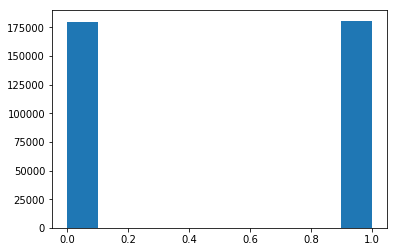

In [408]:
_ = plt.hist(np.array(target))

In [409]:
_X = X[:len(Y)]
Xt = X[len(Y):]
X = _X

In [410]:
clf = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())

In [411]:
clf = make_pipeline(QuantileTransformer(output_distribution='normal'), RandomForestClassifier(n_estimators=100, n_jobs=-1))

In [421]:
clf.fit(X[train_idx], Y[train_idx])
y_diff = Y - clf.predict_proba(X)[:,1]
yt_nb = clf.predict_proba(Xt)[:,1]
Y = y_diff

ValueError: operands could not be broadcast together with shapes (360784,) (560784,) 

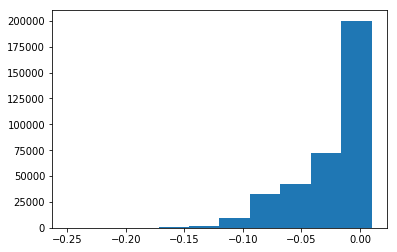

In [413]:
_ = plt.hist(np.array(y_diff))

In [ ]:
qt=clf.steps[0][1]

# replace the original values with the QuantileTransformer values
train_df = pd.DataFrame(data=qt.transform(X), columns=keep_cols)
test_df = pd.DataFrame(data=qt.transform(Xt), columns=keep_cols)
train_df['target'] = target.values

In [ ]:
np.random.seed(13)
train_df_len = len(train_df)
#valid_idx = np.random.permutation(train_df_len)[:train_df_len//10]
train_idx = list(set(range(train_df_len)) - set(valid_idx))

#### Train LGB model

In [8]:
X = train_df[keep_cols]
y = train_df[train_df.columns[0]]

np.random.seed(13)
train_df_len = len(train_df)
perm = np.random.permutation(range(train_df_len))
train_idx = perm[train_df_len//20:]
valid_idx = perm[:train_df_len//20]

In [9]:
dtrain = lgb.Dataset(data=X.values[train_idx],
                     label=y.values[train_idx], 
                     free_raw_data=False, silent=True)
dvalid = lgb.Dataset(data=X.values[valid_idx], 
                     label=y.values[valid_idx], 
                     free_raw_data=False, silent=True)


params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'nthread': 24,
    'learning_rate': 0.2, 
    'is_unbalance' : True,
    'seed': 100,
    'verbose': -1,
    'predict_contrib' : True,
}

clf = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    early_stopping_rounds=200,
    verbose_eval = 100
)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.94661	valid_1's auc: 0.882272
[200]	training's auc: 0.974657	valid_1's auc: 0.891623
[300]	training's auc: 0.988826	valid_1's auc: 0.889932
Early stopping, best iteration is:
[193]	training's auc: 0.973367	valid_1's auc: 0.892272


In [10]:
target_preds = clf.predict(test_df[keep_cols].values)

In [29]:
clf.save_model('repo800feat')

#### Train DL model

In [8]:
# original valid_idx
np.random.seed(13)
train_df_len = len(train_df)
valid_idx = np.random.permutation(range(train_df_len))[:train_df_len//20]
categoricals = []

In [9]:
train_df.loc[valid_idx,'target'].value_counts()

0    8980
1    1020
Name: target, dtype: int64

##### Categoricals

In [38]:
u = [(o, train_df[o].unique().shape[0]) for o in train_df.columns]
categoricals = [o[0] for o in u[1:] if o[-1]/train_df.shape[0] < 0.33]
len(categoricals)

51

In [6]:
for o in categoricals:
    train_df[o] = train_df[o].astype('category')
    test_df[o] = test_df[o].astype('category')

##### Data

In [39]:
data: DataBunch = TabularDataBunch.from_df(path, train_df[['target',]+keep_cols], dep_var='target', 
                                           valid_idx=valid_idx, test_df=test_df[keep_cols], bs=4096,
                                           cat_names=categoricals)

In [40]:
emb_sizes = [o[1]//6 for o in data.get_emb_szs()]
emb_sizes = {k:v for k,v in zip(categoricals, emb_sizes)}

In [45]:
learn = tabular_learner(data, layers=[200,100], metrics=roc(), path='.', ps=0.5, emb_szs=emb_sizes,
                        model_dir=path/'models', emb_drop=0.1)
#learn.model = torch.nn.DataParallel(learn.model)

##### Sample

In [9]:
train_dfs = train_df[['target',]+keep_cols].sample(frac=0.05)
test_dfs = test_df[keep_cols].sample(frac=0.05)
valid_idxs = np.random.permutation(range(len(train_dfs)))[:len(train_dfs)//20]

In [10]:
data_sampled: DataBunch = TabularDataBunch.from_df(path, train_dfs, dep_var='target', 
                                                   valid_idx=valid_idxs, test_df=test_dfs, bs=28, 
                                                   cat_names=categoricals)

In [11]:
learn.data = data_sampled

##### Swap Layer

In [104]:
def swap_layer(model, s, obj):
    children = list(model.children())
    for i,o in enumerate(children[-1]):
        if str(o).find(s) > -1:
            children[-1][i] = obj
swap_layer(learn.model, 'ReLU', nn.Tanh())

##### LR Find

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


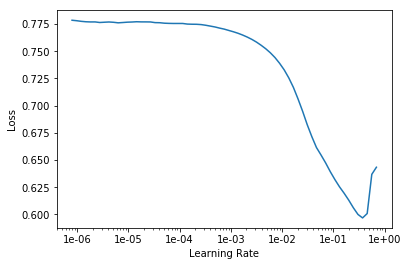

In [42]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [43]:
lr = 1e-1

In [46]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,roc,time
1,0.352838,0.289694,0.867208,00:06
2,0.263694,0.217586,0.883947,00:06
3,0.239187,0.242351,0.889138,00:05
4,0.229730,0.267623,0.889629,00:05
5,0.225292,0.213055,0.887575,00:05
6,0.221234,0.212376,0.887899,00:05
7,0.216588,0.214511,0.889585,00:05
8,0.211407,0.210626,0.890096,00:06
9,0.205208,0.212719,0.887466,00:06
10,0.199710,0.214588,0.887142,00:06


In [ ]:
learn.save('repo800feat')

#### More DL train

In [17]:
class EpochSave(LearnerCallback):
    def __init__(self, learn, fn='tmp'):
        self.learn = learn
        self.fn = fn
        
    def on_epoch_end(self, epoch, **kwargs: Any) -> bool:
        self.learn.save(f'{self.fn}-{epoch}')
        return False

In [19]:
outfn = 'unique_cats'

In [15]:
learn.fit_one_cycle(5, lr, callbacks=[EpochSave(learn, f'{outfn}')])

epoch,train_loss,valid_loss,accuracy,time
1,0.227842,0.262794,0.908100,00:04
2,0.223607,0.288248,0.904850,00:04
3,0.168724,0.370395,0.901250,00:04
4,0.081898,0.537078,0.885000,00:04
5,0.027360,0.763178,0.885850,00:04


In [16]:
learn.save('unique_cats')

In [12]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, path='.', ps=0.95, model_dir=path/'models')

In [13]:
learn = learn.load('unique_cats')

In [20]:
learn.fit_one_cycle(5, lr/10, callbacks=[EpochSave(learn, f'{outfn}')])

epoch,train_loss,valid_loss,accuracy,time
1,0.341915,0.355588,0.897100,00:04
2,0.267784,0.387406,0.896950,00:04
3,0.247250,0.415296,0.896550,00:04
4,0.230192,0.442240,0.894050,00:04
5,0.225289,0.451070,0.893750,00:05


### Submit

#### Re-load learners

In [4]:
test_df = feather.read_dataframe(path/'test_df.feather')
train_df = feather.read_dataframe(path/'train_df.feather')
train_df_len = len(train_df)
valid_idx = range(round(0.90*train_df_len), train_df_len)
with open(path/'keep_cols.pkl', 'rb') as f: keep_cols = pickle.load(f)

In [1]:
data: DataBunch = TabularDataBunch.from_df(path, train_df[['target',]+keep_cols], dep_var='target', 
                                           valid_idx=valid_idx, test_df=test_df[keep_cols], bs=32)

NameError: name 'TabularDataBunch' is not defined

In [2]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, path='.', ps=0.8, model_dir=path/'models')
learn.load('submission_top90pct_extrafeat')

NameError: name 'tabular_learner' is not defined

#### Do preds

In [ ]:
#learn = learn.load('repo800feat')

In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Valid)
valid_preds = preds[0][:,1]
roc_auc_score(train_df.target.values[valid_idx], [0 if o<0.5 else 1 for o in valid_preds])

In [ ]:
#roc_auc_score(Y[valid_idx], clf.predict_proba(X[valid_idx])[:,1])
#####???????

In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test)
target_preds = preds[0][:,1]   ##NB this was item 0 in original code

In [ ]:
_ = plt.hist(np.array(target_preds), bins=5)

In [ ]:
#normalise
tp = [0 if o < 0.2 else 1 for o in target_preds]
_ = plt.hist(np.array(tp))

### Pseudolabel

In [17]:
test_df2 = test_df.copy()
test_df2['target'] = target_preds
test_df2 = test_df2[(test_df2.target<0.04) | (test_df2.target>0.96)]
test_df2.target = test_df2.target.apply(lambda x: 0 if x < 0.5 else 1)
train_df2 = pd.concat([train_df, test_df2], axis=0, sort=False)
train_df2.shape

(239174, 813)

In [25]:
data: DataBunch = TabularDataBunch.from_df(path, train_df2[['target',]+keep_cols], dep_var='target', 
                                           valid_idx=valid_idx, test_df=test_df[keep_cols], bs=512)

learn = tabular_learner(data, layers=[200,100], metrics=roc(), path='.', ps=0.8, model_dir=path/'models')
#learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


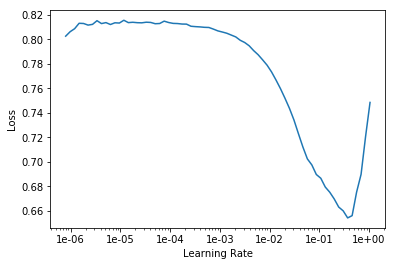

In [19]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [26]:
lr = 1e-2

In [27]:
learn.fit_one_cycle(3,lr)

epoch,train_loss,valid_loss,roc,time
1,0.212398,0.240551,0.881185,00:08
2,0.194570,0.230980,0.889798,00:08
3,0.192462,0.242424,0.889174,00:08


In [28]:
learn.fit_one_cycle(3,lr/10)

epoch,train_loss,valid_loss,roc,time
1,0.192264,0.227022,0.889240,00:08
2,0.191607,0.239398,0.890909,00:08
3,0.188253,0.225663,0.890797,00:08


In [ ]:
learn.save('repo800feat_4layers_pseudo_drop0.9')

In [ ]:
X = train_df2[keep_cols]
y = train_df2[train_df2.columns[0]]

np.random.seed(13)
train_df_len = len(train_df2)
perm = np.random.permutation(range(train_df_len))
train_idx = perm[train_df_len//20:]
valid_idx = perm[:train_df_len//20]

dtrain_all = lgb.Dataset(data=X.values,
                     label=y.values, 
                     free_raw_data=False, silent=True)
dtrain = lgb.Dataset(data=X.values[train_idx],
                     label=y.values[train_idx], 
                     free_raw_data=False, silent=True)
dvalid = lgb.Dataset(data=X.values[valid_idx], 
                     label=y.values[valid_idx], 
                     free_raw_data=False, silent=True)


params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'nthread': 24,
    'learning_rate': 0.2, 
    'is_unbalance' : True,
    'seed': 100,
    'verbose': -1,
    'predict_contrib' : True,
}

cv_result_lgb = lgb.cv(params, 
                       dtrain_all, 
                       num_boost_round=1000, 
                       nfold=5, 
                       stratified=True, 
                       early_stopping_rounds=50, 
                       verbose_eval=100, 
                       show_stdv=True)

In [37]:
num_boost_rounds_lgb = len(cv_result_lgb['auc-mean'])
'num_boost_rounds_lgb=' + str(num_boost_rounds_lgb)

'num_boost_rounds_lgb=182'

In [40]:
# train model
clf = lgb.train(
    params=params,
    train_set=dtrain_all,
    num_boost_round=num_boost_rounds_lgb,
    #valid_sets=[dtrain, dvalid],
    #early_stopping_rounds=200,
    verbose_eval = 100
)

In [41]:
target_preds = clf.predict(test_df[keep_cols].values)
clf.save_model('repo800feat_pseudo_cv')

In [39]:
# train model
clf = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=num_boost_rounds_lgb,
    valid_sets=[dtrain, dvalid],
    early_stopping_rounds=200,
    verbose_eval = 100
)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.955679	valid_1's auc: 0.90497
Did not meet early stopping. Best iteration is:
[182]	training's auc: 0.975846	valid_1's auc: 0.910433


### Submit

In [42]:
test_df['ID_code'] = test_ID_codes_df
test_df['target'] = target_preds

name = 'repo800feat_pseudo_cv'
test_df.to_csv(path/f'subs/{name}.csv.gz', columns=['ID_code', 'target'], index=False, compression='gzip')

In [33]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f {path}/subs/{name}.csv.gz -m "{name}"

100%|██████████████████████████████████████| 2.27M/2.27M [00:01<00:00, 72.3kB/s]
Successfully submitted to Santander Customer Transaction Prediction